# Advanced PSF modeling

Ideally we always have plenty of well separated bright, but not oversaturated, stars to use to construct a PSF model. These models are incredibly important for certain science objectives that rely on precise shape measurements and not just total light measures. Here we demonstrate some of the special capabilities AstroPhot has to handle challenging scenarios where a good PSF model is needed but there are only very faint stars, poorly placed stars, or even no stars to work with!

In [1]:
import astrophot as ap
import numpy as np
import torch
from astropy.io import fits
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

# PSF modeling without stars

Can it be done? Let's see!

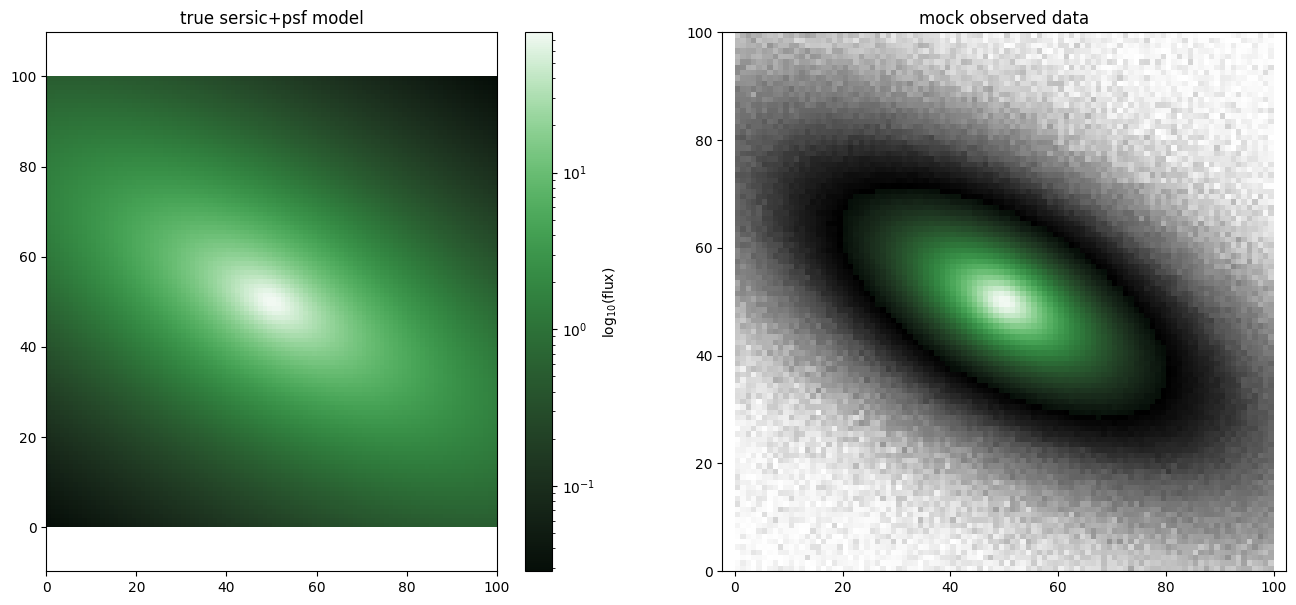

In [2]:
# Lets make some data that we need to fit

true_psf = ap.utils.initialize.moffat_psf(
    2., # n                                !!!!! Take note, we want to get n = 2. !!!!!! 
    3., # Rd                               !!!!! Take note, we want to get Rd = 3.!!!!!!
    51, # pixels
    1.  # pixelscale
)

target = ap.image.Target_Image(
    data = torch.zeros(100,100), 
    pixelscale = 1.,
    psf = true_psf,
)

true_model = ap.models.AstroPhot_Model(
    name = "true model",
    model_type = "sersic galaxy model",
    target = target,
    parameters = {
        "center": [50.,50.],
        "q": 0.4,
        "PA": np.pi/3,
        "n": 2,
        "Re": 25,
        "Ie": 1,
    },
    psf_mode = "full",
)

# use the true model to make some data
sample = true_model()
torch.manual_seed(61803398)
target.data = sample.data + torch.normal(torch.zeros_like(sample.data), 0.1)
target.variance = 0.01*torch.ones_like(sample.data)

fig, ax = plt.subplots(1,2, figsize = (16,7))
ap.plots.model_image(fig, ax[0], true_model)
ap.plots.target_image(fig, ax[1], target)
ax[0].set_title("true sersic+psf model")
ax[1].set_title("mock observed data")
plt.show()

In [3]:
# Now we will try and fit the data using just a plain sersic

# Here we set up a sersic model for the galaxy
plain_galaxy_model = ap.models.AstroPhot_Model(
    name = "galaxy model",
    model_type = "sersic galaxy model",
    target = target,
)

# Let AstroPhot determine its own intial parameters, so it has to start with whatever it decides automatically, 
# just like a real fit.
plain_galaxy_model.initialize()

result = ap.fit.LM(plain_galaxy_model, verbose = 1).fit()
print(result.message)

Chi^2: 70.853602702409, L: 1.0
Chi^2: 33.20959269179375, L: 0.3333333333333333
Chi^2: 25.755182233710112, L: 0.1111111111111111
Chi^2: 23.534292011098653, L: 0.012345679012345678
Chi^2: 23.52279661269229, L: 1.693508780843029e-05
Chi^2: 23.522745806171965, L: 5.645029269476763e-06
Final Chi^2: 23.52274527850335, L: 1.881676423158921e-06. Converged: success
success


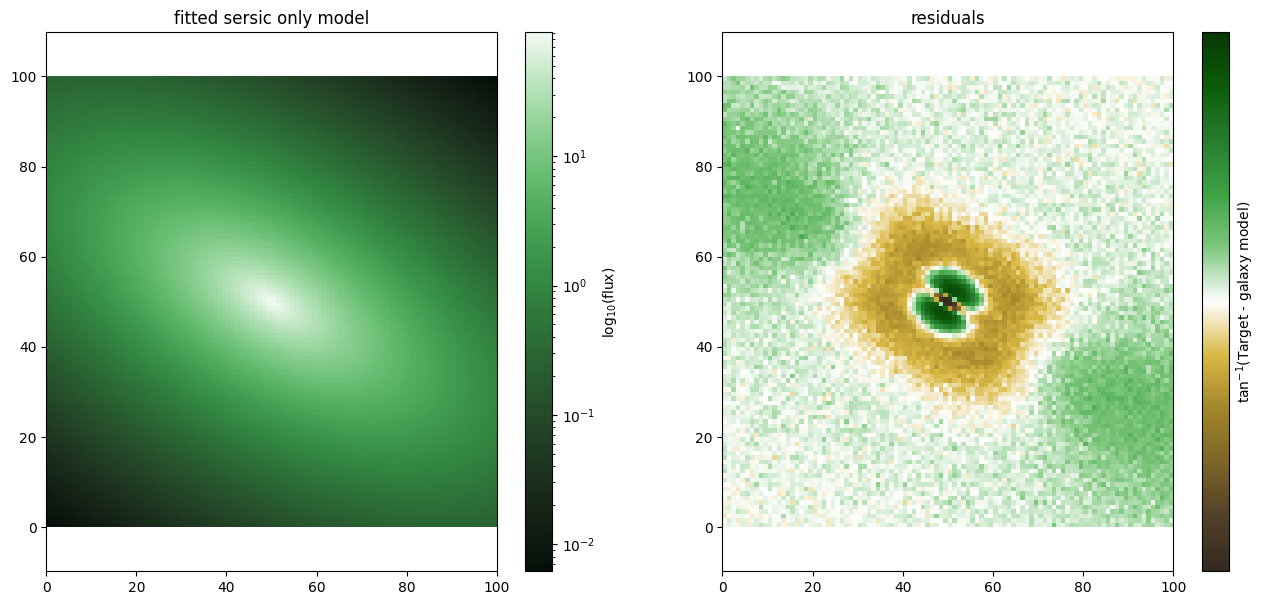

In [4]:
# The shape of the residuals here shows that there is still missing information; this is of course
# from the missing PSF convolution to blur the model. In fact, the shape of those residuals is very
# commonly seen in real observed data (ground based) when it is fit without accounting for PSF blurring.
fig, ax = plt.subplots(1,2, figsize = (16,7))
ap.plots.model_image(fig, ax[0], plain_galaxy_model)
ap.plots.residual_image(fig, ax[1], plain_galaxy_model)
ax[0].set_title("fitted sersic only model")
ax[1].set_title("residuals")
plt.show()

In [5]:
# Now we will try and fit the data with a sersic model and a "live" psf

# Here we create a moffat model for the PSF. Note that this is just a regular AstroPhot model that we have chosen 
# to be a moffat, really any model can be used. To make it suitable as a PSF we will need to apply some very 
# specific settings. The window for the model is now just used to set the size of the PSF (51 by 51 pixels).
# The "center" must be put at the center of the window (note that this is a bit harder when pixelscale != 1).
# The "I0" value doesn't matter for a PSF (which will be normalized internally), we pick I0 = 1 just for 
# numerical stability. The "psf_upscale" parameter is set to 1 just to indicate we are not doing any super
# resolution fitting this time.
live_psf_model = ap.models.AstroPhot_Model(
    name = "psf",
    model_type = "moffat star model",
    target = target,
    window = [[0,51],[0,51]],
    parameters = {
        "n": 1., # True value is 2.
        "Rd": 2., # True value is 3.
        "center": {"value": [25.5,25.5], "locked":True},
        "I0": {"value": 1., "locked":True},
    },
)

# Here we set up a sersic model for the galaxy
live_galaxy_model = ap.models.AstroPhot_Model(
    name = "galaxy model",
    model_type = "sersic galaxy model",
    target = target,
    psf_mode = "full",
    psf = live_psf_model, # Here we bind the PSF model to the galaxy model, this will add the psf_model parameters to the galaxy_model
)

live_galaxy_model.initialize()

result = ap.fit.LM(live_galaxy_model, verbose = 1).fit()
result.update_uncertainty()

Chi^2: 1122.453342613391, L: 1.0
Chi^2: 852.2738603094667, L: 1.6666666666666667
Chi^2: 84.02218345081738, L: 0.5555555555555556
Chi^2: 12.893595496346206, L: 0.1851851851851852
Chi^2: 9.415599936917657, L: 0.0617283950617284
Chi^2: 8.74760809728311, L: 0.10288065843621401
Chi^2: 6.236420175576896, L: 0.03429355281207134
Chi^2: 2.3268575799867706, L: 0.011431184270690446
Chi^2: 1.2481028883635592, L: 0.0038103947568968156
Chi^2: 0.9962403106102826, L: 0.001270131585632272
Chi^2: 0.9929956412512642, L: 1.7422929844064085e-06
Chi^2: 0.9929955231491641, L: 5.807643281354695e-07
Final Chi^2: 0.9929955231490603, L: 2.1509789930943314e-08. Converged: success


In [6]:
print("fitted n for moffat PSF: ", live_galaxy_model["psf:n"].value.item(), "we were hoping to get 2!")
print("fitted Rd for moffat PSF: ", live_galaxy_model["psf:Rd"].value.item(), "we were hoping to get 3!")
print(live_galaxy_model.parameters)

fitted n for moffat PSF:  1.9952464194447397 we were hoping to get 2!
fitted Rd for moffat PSF:  2.972340397415358 we were hoping to get 3!
Parameter Group: galaxy model
center: [25.5, 25.5] +- None [arcsec, locked]
n: 1.9952464194447397 +- 0.012799404231285103 [none, (0.1, 10.0)]
Rd: 2.972340397415358 +- 0.012574434538574488 [arcsec, (0.0, 'None')]
I0: 1.0 +- None [log10(flux/arcsec^2), locked]
center: [50.00213969345104, 49.99872327175124] +- [0.0015637301450847976, 0.001167111468242571] [arcsec]
q: 0.4006732240391433 +- 0.0007932093092819072 [b/a, (0.0, 1.0)]
PA: 1.0468726647851947 +- 0.00018140397979243882 [radians, (0.0, 3.141592653589793), cyclic]
n: 1.9926241233819493 +- 0.005837348359772274 [none, (0.36, 8.0)]
Re: 24.952783031776594 +- 0.02094753222704638 [arcsec, (0.0, 'None')]
Ie: 1.001186019520792 +- 0.0007932478945847528 [log10(flux/arcsec^2)]


This is truly remarkable! With no stars available we were still able to extract an accurate PSF from the image! To be fair, this example is essentially perfect for this kind of fitting and we knew the true model types (sersic and moffat) from the start. Still, this is a powerful capability in certain scenarios. For many applications (e.g. weak lensing) it is essential to get the absolute best PSF model possible. Here we have shown that not only stars, but galaxies in the field can be useful tools for measuring the PSF!

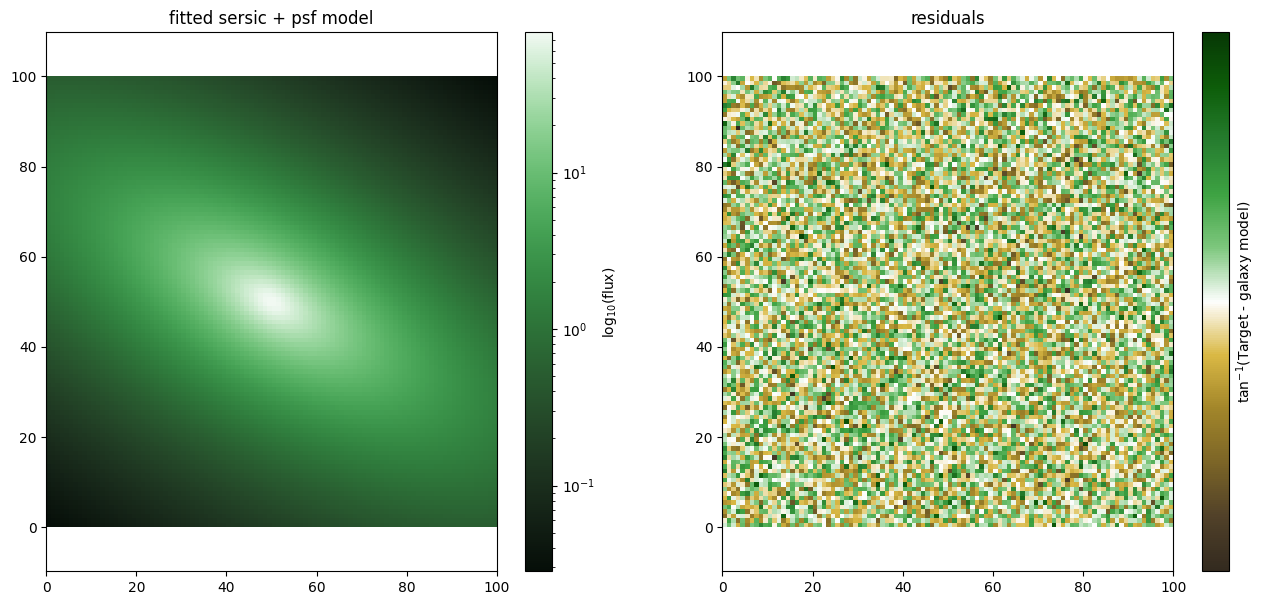

In [7]:
fig, ax = plt.subplots(1,2, figsize = (16,7))
ap.plots.model_image(fig, ax[0], live_galaxy_model)
ap.plots.residual_image(fig, ax[1], live_galaxy_model)
ax[0].set_title("fitted sersic + psf model")
ax[1].set_title("residuals")
plt.show()

There are regions of parameter space that are degenerate and so even in this idealized scenario the PSF model can get stuck. If you rerun the notebook with different random number seeds for pytorch you may find some where the optimizer "fails by immobility" this is when it get's stuck in the parameter space and can't find any way to improve the likelihood. In fact most of these "fail" fits do return really good values for the PSF model, so keep in mind that the "fail" flag only means the possibility of a truly failed fit. Unfortunatly, detecting convergence is hard.

## PSF fitting with a bad star

Fitting a PSF to a galaxy is perhaps not the most stable way to get a good model. However, there is a very common situation where this kind of fitting is quite helpful. Consider the scenario that there is a star, but it is not very bright and it is right next to a galaxy. Now we need to model the galaxy and the star simultaneously, but the galaxy should be convolved with the PSF for the fit to be stable (otherwise you'll have to do several iterations to converge). If there were many stars you could perhaps just stack a bunch of them and hope the average is close enough, but in this case we don't have many to work with so we need to squeeze out as much statistical power as possible. 

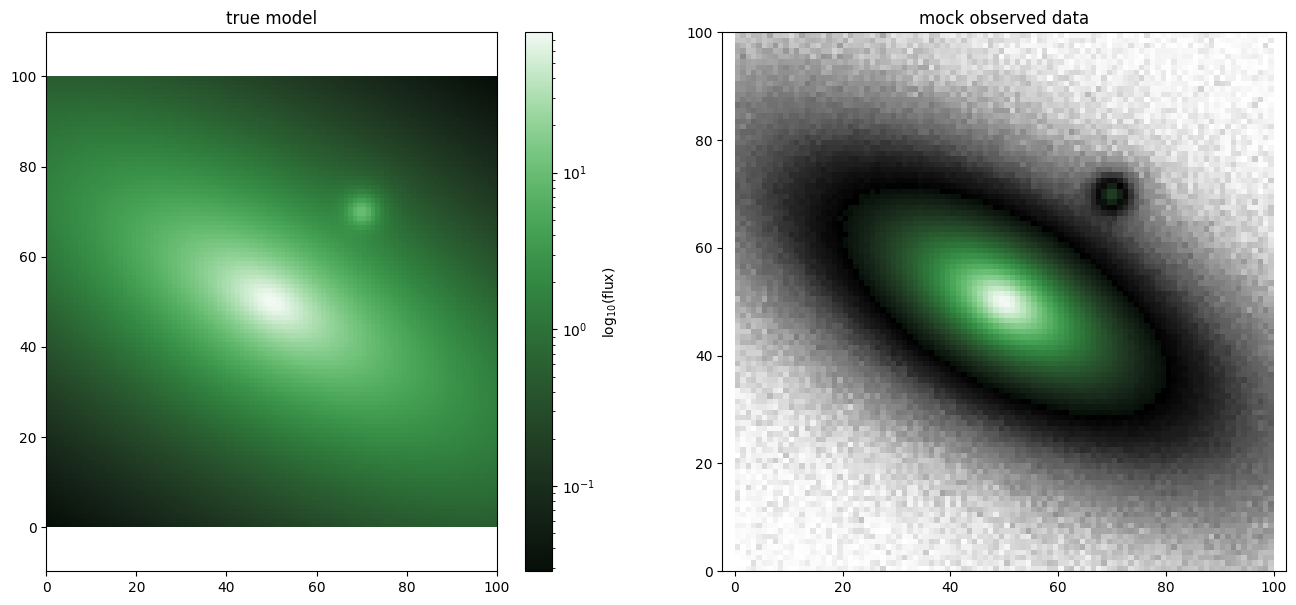

In [8]:
# Lets make some data that we need to fit

true_psf2 = ap.utils.initialize.moffat_psf(
    2., # n                                !!!!! Take note, we want to get n = 2. !!!!!! 
    3., # Rd                               !!!!! Take note, we want to get Rd = 3.!!!!!!
    51, # pixels
    1.  # pixelscale
)

target2 = ap.image.Target_Image(
    data = torch.zeros(100,100), 
    pixelscale = 1.,
    psf = true_psf,
)

true_galaxy2 = ap.models.AstroPhot_Model(
    name = "true galaxy",
    model_type = "sersic galaxy model",
    target = target2,
    parameters = {
        "center": [50.,50.],
        "q": 0.4,
        "PA": np.pi/3,
        "n": 2,
        "Re": 25,
        "Ie": 1,
    },
    psf_mode = "full",
)
true_star2 = ap.models.AstroPhot_Model(
    name = "true star",
    model_type = "moffat star model",
    target = target2,
    parameters = {
        "center": [70,70],
        "n": 2,
        "Rd": 3,
        "I0": 1.,
    },
)
true_model2 = ap.models.AstroPhot_Model(
    name = "true model",
    model_type = "group model",
    target = target2,
    models = [true_galaxy2, true_star2],
)

# use the true model to make some data
sample2 = true_model2()
torch.manual_seed(1618033988)
target2.data = sample2.data + torch.normal(torch.zeros_like(sample2.data), 0.1)
target2.variance = 0.01 * torch.ones_like(sample2.data)

fig, ax = plt.subplots(1,2, figsize = (16,7))
ap.plots.model_image(fig, ax[0], true_model2)
ap.plots.target_image(fig, ax[1], target2)
ax[0].set_title("true model")
ax[1].set_title("mock observed data")
plt.show()

In [9]:
# Now we will try and fit the data

psf_model2 = ap.models.AstroPhot_Model(
    name = "psf",
    model_type = "moffat star model",
    target = target2,
    window = [[0,51],[0,51]],
    parameters = {
        "n": 1., # True value is 2.
        "Rd": 2., # True value is 3.
        "center": {"value": [25.5,25.5], "locked":True},
        "I0": {"value": 1., "locked":True},
    },
)

# Here we set up a sersic model for the galaxy
galaxy_model2 = ap.models.AstroPhot_Model(
    name = "galaxy model",
    model_type = "sersic galaxy model",
    target = target,
    psf_mode = "full",
    psf = psf_model2,
)

# Let AstroPhot determine its own intial parameters, so it has to start with whatever it decides automatically, 
# just like a real fit.
galaxy_model2.initialize()

star_model2 = ap.models.AstroPhot_Model(
    name = "star model",
    model_type = "moffat star model",
    target = target2,
    parameters = {
        "center": [72,68], # start the star in roughly the right location
    },
)

star_model2.initialize()

star_model2.add_equality_constraint(psf_model2, ["n", "Rd"])

full_model2 = ap.models.AstroPhot_Model(
    name = "full model",
    model_type = "group model",
    models = [galaxy_model2, star_model2],
    target = target2,
)

result = ap.fit.LM(full_model2, verbose = 1).fit()

Chi^2: 1125.8424509402028, L: 1.0
Chi^2: 880.8551502872203, L: 0.3333333333333333
Chi^2: 18.95979713110136, L: 0.5555555555555555
Chi^2: 11.48860562960478, L: 0.18518518518518515
Chi^2: 8.158194159869048, L: 0.061728395061728385
Chi^2: 3.55574510452728, L: 0.020576131687242795
Chi^2: 1.3848949220300502, L: 0.006858710562414265
Chi^2: 1.0858439911745974, L: 0.0022862368541380885
Chi^2: 0.9984181350826176, L: 3.136127371931534e-06
Chi^2: 0.9983823998352208, L: 1.0453757906438446e-06
Chi^2: 0.9983823996507339, L: 3.4845859688128153e-07
Final Chi^2: 0.9983823996507334, L: 1.2905873958565983e-08. Converged: success


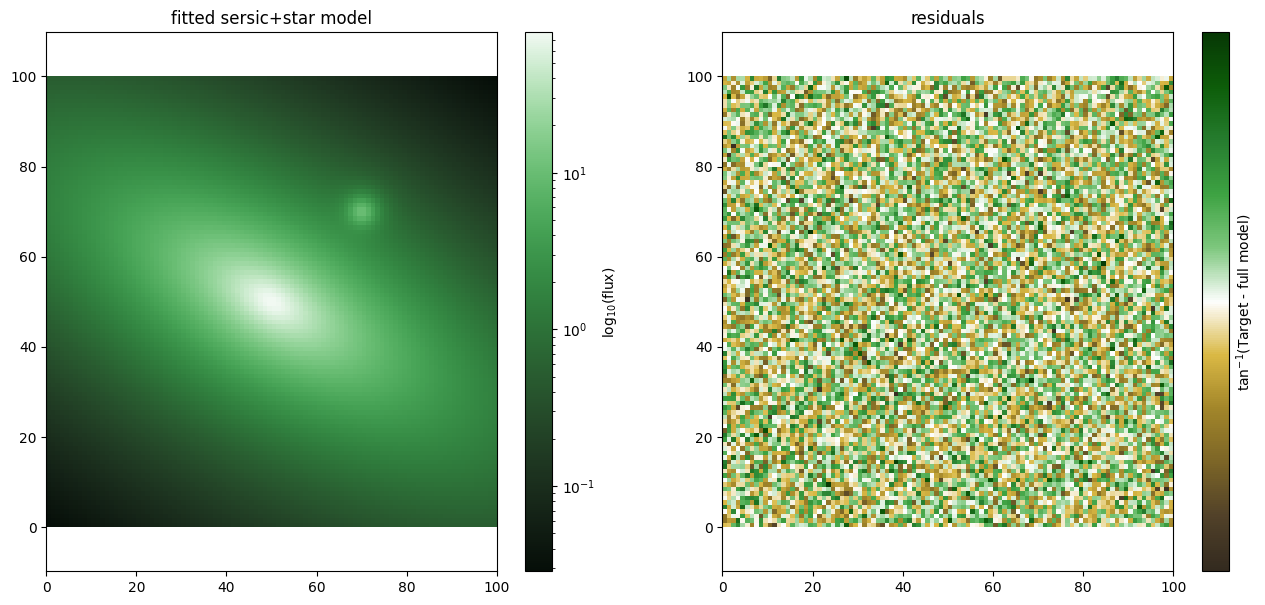

In [10]:
fig, ax = plt.subplots(1,2, figsize = (16,7))
ap.plots.model_image(fig, ax[0], full_model2)
ap.plots.residual_image(fig, ax[1], full_model2)
ax[0].set_title("fitted sersic+star model")
ax[1].set_title("residuals")
plt.show()

In [11]:
print("fitted n for moffat PSF: ", galaxy_model2["psf:n"].value.item(), "we were hoping to get 2!")
print("fitted Rd for moffat PSF: ", galaxy_model2["psf:Rd"].value.item(), "we were hoping to get 3!")

print("---Note that we can just as well look at the star model parameters since they are the same---")
print("fitted n for moffat PSF: ", star_model2["n"].value.item(), "we were hoping to get 2!")
print("fitted Rd for moffat PSF: ", star_model2["Rd"].value.item(), "we were hoping to get 3!")

fitted n for moffat PSF:  1.974299950162938 we were hoping to get 2!
fitted Rd for moffat PSF:  2.981986632472097 we were hoping to get 3!
---Note that we can just as well look at the star model parameters since they are the same---
fitted n for moffat PSF:  1.974299950162938 we were hoping to get 2!
fitted Rd for moffat PSF:  2.981986632472097 we were hoping to get 3!


Note that the fitted moffat parameters aren't much better than they were earlier when we just fit the galaxy alone. This shows us that extended objects have plenty of constraining power when it comes to PSF fitting, all this information has previously been left on the table! It makes sense that the galaxy dominates the PSF fit here, while the star is very simple to fit, it has much less light than the galaxy in this scenario so the S/N for the galaxy dominates. The reason this works really well is of course that the true data is in fact a sersic model, so we are working in a very idealized scenario. Real world galaxies are not necessarily well described by a sersic, so it is worthwhile to be cautious when doing this kind of fitting. Always make sure the results make sense before storming ahead with galaxy based PSF models, that said the payoff can be well worth it.

# PSF fitting for faint stars

Sometimes there are stars available, but they are faint and it is hard to see how a reliable fit could be obtained. We have already seen how faint stars next to galaxies are still viable for PSF fitting. Now we will consider the case of isolated but faint stars. The trick here is that we have a second high resolution image, perhaps in a different band. To perform this fitting we will link up the two bands using joint modelling to constrain the star centers, this will constrain some of the parameters making it easier to fit a PSF model.

In [12]:
# Coming soon

# PSF fitting for saturated stars

A saturated star is a bright star, and it's just begging to be used for modelling a PSF. There's just one catch, the highest signal to noise region is completely messed up and can't be used! Traditionally these stars are either ignored, or a two stage fit is performed to get an "inner psf" and an "outer psf" which are then merged. Why not fit the inner and outer PSFs all at once! This can be done with AstroPhot using parameter constraints and masking.

In [13]:
# Coming soon